In [617]:
from avaframe.in2Trans.ascUtils import readRaster
from pathlib import Path
import os
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.patches import Polygon
import json

from matplotlib.path import Path as mplPath
from matplotlib.colors import ListedColormap
from avaframe.in2Trans.shpConversion import SHP2Array

sim_case = "avaWog"
avaframe_dir = Path(r"C:\git\snow_avalanches\AvaFrame\avaframe\data")
webigeo_app_dir = Path(r"C:\git\webigeo\cmake-build-release-visual-studio")


webigeo_export_dir = webigeo_app_dir / "export"
webigeo_sim_dir = webigeo_export_dir / sim_case
sim_case_dir = avaframe_dir / sim_case
avaframe_input_dir = sim_case_dir / "Inputs"
avaframe_output_dir = sim_case_dir / "Outputs" / "com1DFA"
webigeo_to_avaframe_output_dir = sim_case_dir / "Outputs" / "webigeo"
avaframe_output_peak_dir = avaframe_output_dir / "peakFiles"
release_path = avaframe_input_dir / "REL"
release_scenerios = [file.replace(".shp", "") for file in os.listdir(release_path) if file.endswith(".shp")]
print("Release scenarios:", release_scenerios)

def get_dem(path: Path) -> tuple[dict, np.ndarray]:
    files = [file for file in os.listdir(path) if file.endswith(".asc")]
    assert len(files) == 1, "There should be exactly one .asc file with the DEM in the directory"
    dem_file = path / files[0]
    dem = readRaster(dem_file, noDataToNan=True)
    return dem["header"], dem["rasterData"]

def get_release_areas(filename: Path) -> list[Polygon]:
    release = SHP2Array(filename)
    release_areas = []
    for start, length in zip(release["Start"], release["Length"]):
        start = round(start)
        length = round(length)
        x_meters = release["x"][start:start + length]
        y_meters = release["y"][start:start + length]
        # x_pixel = [round((value - dem_header["xllcenter"]) / dem_header["cellsize"]) for value in x_meters]
        # y_pixel = [round((value - dem_header["yllcenter"]) / dem_header["cellsize"]) for value in y_meters]
        release_areas.append(Polygon(list(zip(x_meters, y_meters)), closed=True, edgecolor='red', facecolor='pink', alpha=0.8))
    return release_areas

def dem_np_to_webigeo(path: Path, dem_header: dict, height_data: np.ndarray) -> np.ndarray:
    min_height = height_data.min()
    if min_height < 0:
        height_data = height_data - min_height
    height_data = height_data + 500
    # Normalize the height data to range between 0 and 8191.875
    min_height = 0
    max_height = 8191.875

    # Scale height values to 16-bit unsigned integer range (0 to 65535)
    scaled_heights = np.clip(height_data, min_height, max_height)
    scaled_heights = (scaled_heights / max_height) * 65535
    scaled_heights = scaled_heights.astype(np.uint16)

    # Extract the higher 8 bits for the Red channel and the lower 8 bits for the Green channel
    red_channel = ((scaled_heights >> 8) & 0xFF).astype(np.uint8)   # High 8 bits
    green_channel = (scaled_heights & 0xFF).astype(np.uint8)         # Low 8 bits

    # Create the RGBA image: 
    # Red (R), Green (G), Blue (B), and Alpha (A)
    blue_channel = np.zeros_like(red_channel, dtype=np.uint8)
    alpha_channel = np.full_like(red_channel, 255, dtype=np.uint8)  # Fully opaque alpha

    # Stack channels into a 4-channel image
    rgba_image = np.stack((red_channel, green_channel, blue_channel, alpha_channel), axis=-1)

    # Convert the array to a PIL Image
    image = Image.fromarray(rgba_image).transpose(Image.FLIP_TOP_BOTTOM)

    # Save the image as a PNG
    image.save(path / "texture.png", "PNG")
    # "Bounds file must contain exactly 4 lines: min_x, min_y, max_x, max_y")
    x_min = dem_header["xllcenter"]
    y_min = dem_header["yllcenter"]
    x_max = dem_header["xllcenter"] + dem_header["ncols"] * dem_header["cellsize"]
    y_max = dem_header["yllcenter"] + dem_header["nrows"] * dem_header["cellsize"]

    with open(path / "aabb.txt", "w") as bounds_file:
        bounds_file.write(f"{x_min}\n")
        bounds_file.write(f"{y_min}\n")
        bounds_file.write(f"{x_max}\n")
        bounds_file.write(f"{y_max}\n")
    return height_data

def export_webigeo_release_points(path: Path, xx: np.ndarray, yy: np.ndarray, release_areas: list[Polygon]) -> Image:
    points = np.vstack((xx.ravel(), yy.ravel())).T
    grid = np.zeros(xx.shape, dtype=bool)
    # Combine masks for all polygons
    for polygon in release_areas:  
        mplpath = mplPath(polygon.get_xy())# Create a Path object for the polygon
        mask = mplpath.contains_points(points).reshape(grid.shape)  # Create a mask for the polygon
        grid[mask] = True  # Combine the mask into the grid
    red_channel = np.zeros(xx.shape, dtype=np.uint8)
    red_channel[grid] = 255  # High 8 bits
    green_channel = np.zeros_like(red_channel, dtype=np.uint8) 
    blue_channel = np.zeros_like(red_channel, dtype=np.uint8)
    alpha_channel = red_channel # Fully opaque alpha

    # Stack channels into a 4-channel image
    rgba_image = np.stack((red_channel, green_channel, blue_channel, alpha_channel), axis=-1)
    image = Image.fromarray(rgba_image).transpose(Image.FLIP_TOP_BOTTOM)
    
    image.save(path / "texture.png", "PNG")
    return image

def export_webigeo_settings(path: Path, persistence: float=0.7, random_contribution: float=0.1, alpha:float =25, num_paths_per_release_cell: int=4096, num_steps: int=2048) -> dict:
    settings = {
        "alpha": alpha,
        "num_paths_per_release_cell": num_paths_per_release_cell,
        "num_steps": num_steps,
        "persistence_contribution": persistence,
        "random_contribution": random_contribution,
        "release_point_interval": 8,
        "source_zoomlevel": 15,
        "tile_source": "dtm",
        "trajectory_resolution_multiplier": 1,
        "trigger_point_max_slope_angle": 45,
        "trigger_point_min_slope_angle": 30
    }
    settings_path = path / "settings.json"
    json.dump(settings, open(settings_path, "w"), indent=4)
    return settings

def plot_inputs(xx: np.ndarray, yy: np.ndarray, dem: np.ndarray, release_areas: list[Polygon]):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_aspect('equal')
    plot_dem(ax, dem, xx, yy)
    
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_title('Visualization of DEM and release areas')

    for polygon in release_areas:
        new_polygon = Polygon(polygon.get_xy(), closed=True, edgecolor='red', facecolor='pink', alpha=0.5)
        ax.add_patch(new_polygon)
    return fig, ax

def plot_dem_3d(xx, yy, dem):# Plot the DEM in 3D
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    surf = ax.plot_surface(xx, yy, dem, cmap='terrain', edgecolor='none')

    # Add a colorbar
    cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
    cbar.set_label('Elevation (m)')

    # Set labels and title
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_zlabel('Elevation (m)')
    ax.set_title('3D Visualization of DEM')
    ax.set_aspect('equal')

def plot_dem(ax, dem, xx, yy):
    # DEM
    levels_dem = np.arange(0, 4000, 200)
    ax.contourf(xx, yy, dem, levels=levels_dem, cmap='Greys')
    CS = ax.contour(xx, yy, dem, levels=levels_dem, linewidths=.5, colors="black")
    ax.clabel(CS, fontsize=10)

def get_levels(data):
    return np.arange(0.01, (int(data.max()/10) + 2) * 10, 10)

def plot_flow_velocity(flow_velocity, dem, xx, yy, title="Flow Velocity"):
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_aspect('equal')
    plot_dem(ax, dem, xx, yy)
    surf = ax.contourf(xx, yy, flow_velocity, cmap='viridis', levels=get_levels(flow_velocity), vmin=0.01)
    cbar = fig.colorbar(surf, ax=ax)
    cbar.set_label("Flow Velocity (m/s)")
    ax.set(title=title)
    return fig, ax


Release scenarios: ['relWog']


In [550]:
dem_header, dem = get_dem(avaframe_input_dir)
y = np.arange(0, dem_header["nrows"] * dem_header["cellsize"],  dem_header["cellsize"]) + dem_header["yllcenter"]
x = np.arange(0, dem_header["ncols"] * dem_header["cellsize"],  dem_header["cellsize"]) + dem_header["xllcenter"]
xx, yy = np.meshgrid(x, y)
# np.nan_to_num

for release_scenerio in release_scenerios:
    release_areas = get_release_areas(release_path / (release_scenerio + ".shp"))
    webigeo_export_path = webigeo_app_dir / "input" / (sim_case + "_" + release_scenerio)
    webigeo_export_release_points_path = webigeo_export_path / "release_points"
    webigeo_export_dem_path = webigeo_export_path / "heights"
    os.makedirs(webigeo_export_path, exist_ok=True)
    os.makedirs(webigeo_export_release_points_path, exist_ok=True)
    os.makedirs(webigeo_export_dem_path, exist_ok=True)
    corrected_dem = dem_np_to_webigeo(webigeo_export_dem_path, dem_header, dem)
    export_webigeo_release_points(webigeo_export_release_points_path, xx, yy, release_areas)
    export_webigeo_settings(webigeo_export_path, num_paths_per_release_cell=256, num_steps=2048)
    

C:\Users\magge\AppData\Local\Temp\ipykernel_7396\2468834305.py:61: RuntimeWarning: invalid value encountered in cast
  scaled_heights = scaled_heights.astype(np.uint16)


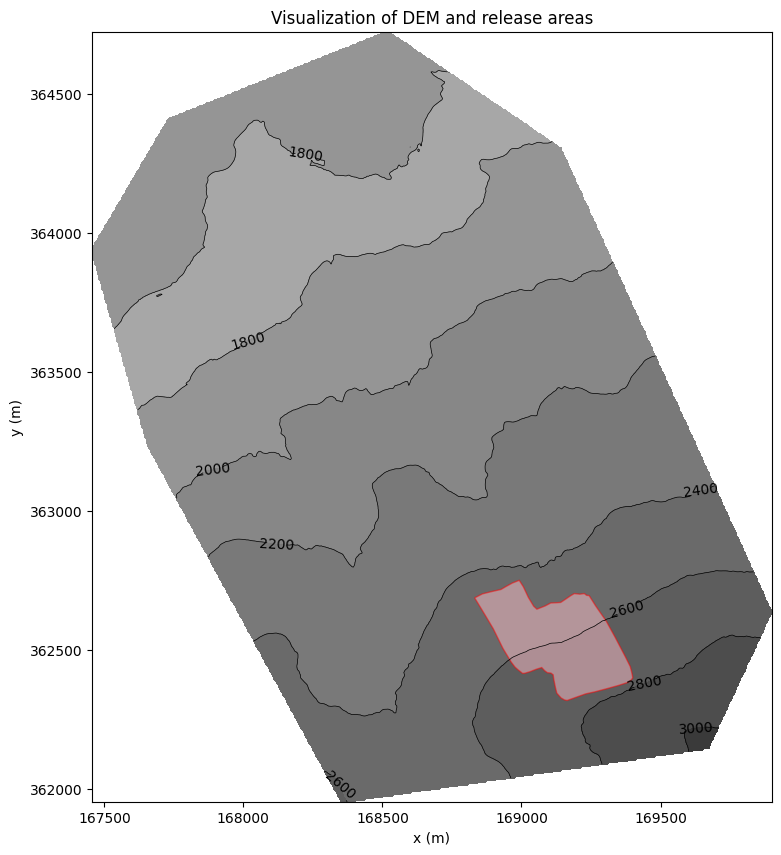

In [474]:
plot_inputs(xx, yy, corrected_dem, release_areas)

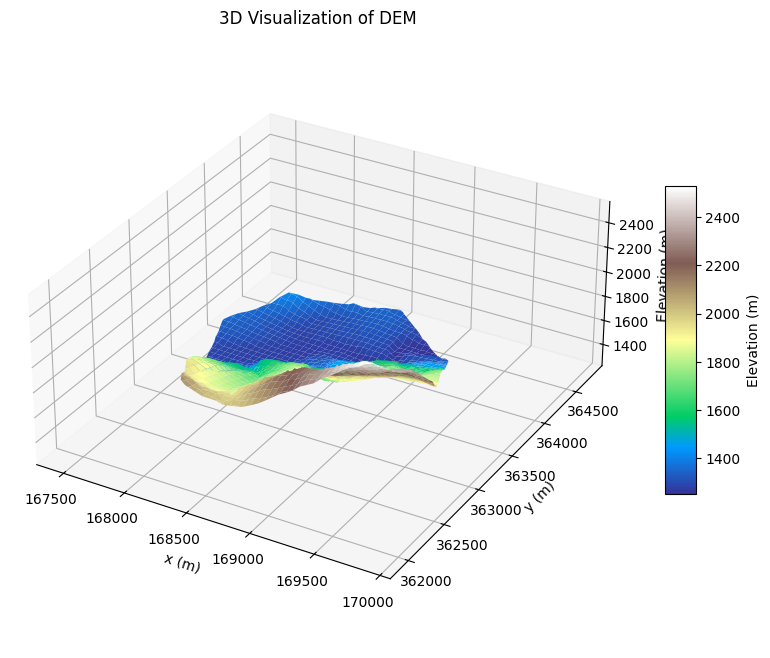

In [476]:
plot_dem_3d(xx, yy, dem)

In [560]:
files = [file for file in os.listdir(avaframe_output_peak_dir) if file.endswith("pfv.asc") if file.find("null") != -1]
print(avaframe_output_dir)
print(files)
flow_velocity_file = avaframe_output_peak_dir / files[0]
dfa_flow_velocity = np.zeros_like(dem)
flow_velocity = readRaster(flow_velocity_file, noDataToNan=True)
flow_velocity_header = flow_velocity["header"]
flow_velocity = flow_velocity["rasterData"]
dfa_flow_velocity[:flow_velocity.shape[0], :flow_velocity.shape[1]] = flow_velocity


C:\git\snow_avalanches\AvaFrame\avaframe\data\avaWog\Outputs\com1DFA
['relWog_fcfa9c273d_C_L_null_dfa_pfv.asc']


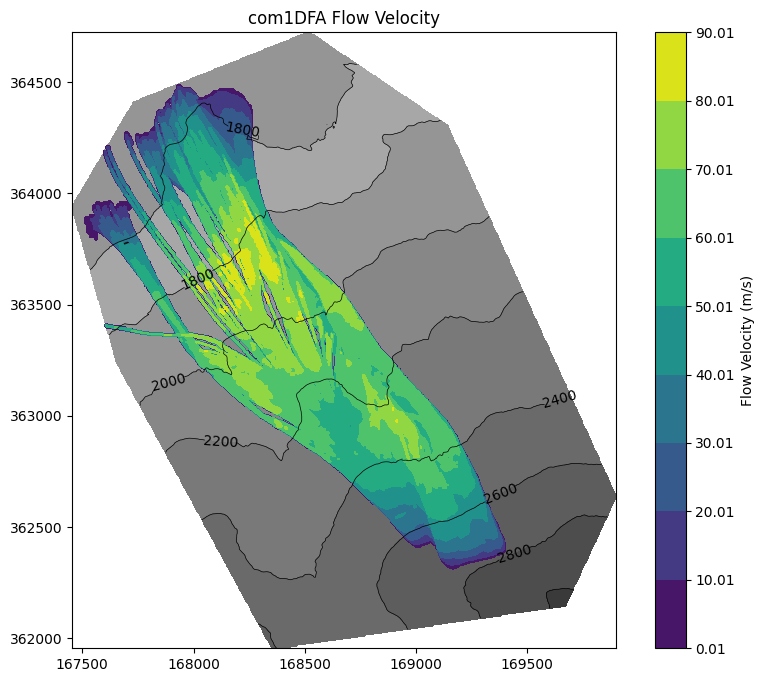

In [565]:

plot_flow_velocity(dfa_flow_velocity, corrected_dem, xx, yy, title="com1DFA Flow Velocity");

In [382]:
os.listdir(webigeo_export_dir / (sim_case + "_" + release_scenerio))
# C:\git\webigeo\cmake-build-release-visual-studio\export\avaPyramid45_release1PY

['pers_0.70_rand_0.10_n_4096_l_1_res_1_a_0.44']

(1039, 1039, 4)


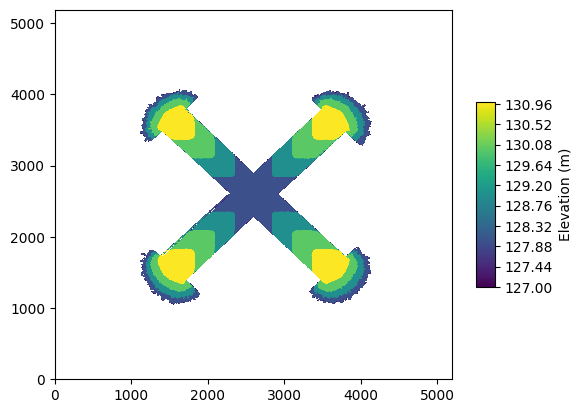

In [386]:
d = webigeo_export_dir / (sim_case + "_" + release_scenerio)
sim_cases = os.listdir(d)

for case in sim_cases:
    png_filename = d / case / r"trajectories\texture_layer1_zdelta.png"
    # png_filename = r"C:\git\webigeo\build\Desktop_Qt_6_8_0_MSVC2022_64bit-Debug\export_2025-04-27_20-05-04.3268694\heights\texture.png"
    height_encoding = "little"  # or "big"
    # Open the PNG image
    img = Image.open(png_filename)
    img = img.convert("RGBA")  # Ensure it has 4 channels

    # Load image data into a NumPy array
    data = np.array(img)

    red = data[:, :, 0].astype(np.uint8)
    green = data[:, :, 1].astype(np.uint8)

    # Combine red and green channels based on endian
    if height_encoding == "big":
        uint16_data = (red << 8) | green
    elif height_encoding == "little":
        uint16_data = (green << 8) | red
    else:
        raise ValueError("Invalid endian type. Use 'big' or 'little'.")
    ava_extend = np.zeros((data.shape[0], data.shape[1]), dtype=np.uint8)
    ava_extend[data[:, :, 3] > 0] = 1
    print(data.shape)
    fig, ax = plt.subplots()
    uint16_data = uint16_data
    velocity = np.sqrt(uint16_data * 2 * 9.81)
    # ax.imshow(ava_extend, cmap='gray')
    cont = ax.contourf(x, y, uint16_data, levels=100, cmap='viridis')
    cbar = fig.colorbar(cont, ax=ax, shrink=0.5, aspect=10)
    cbar.set_label('Elevation (m)')

C:\Users\magge\AppData\Local\Temp\ipykernel_7396\317561823.py:22: RuntimeWarning: invalid value encountered in sqrt
  return np.nan_to_num(np.sqrt(clamped_pixel * 2 * 9.81))


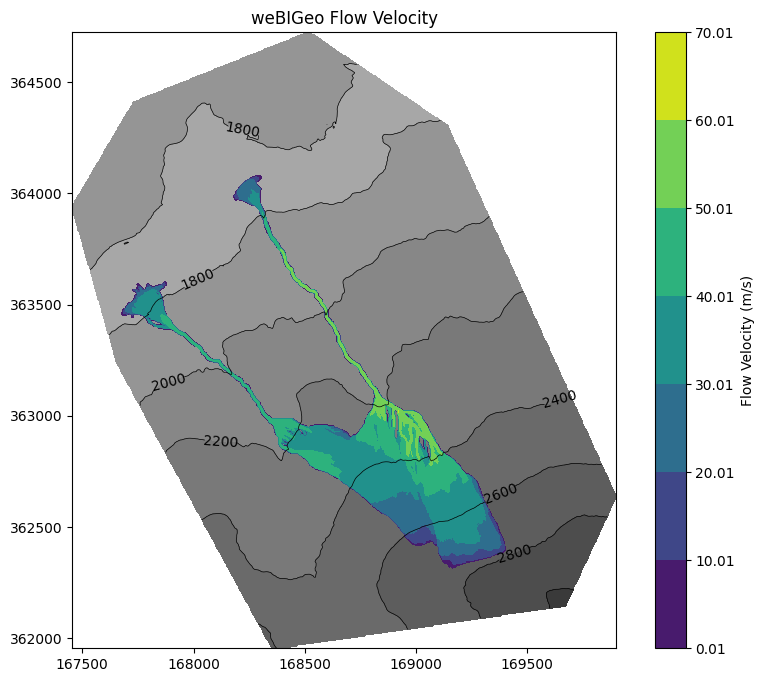

In [594]:
def read_webigeo_flow_velocity(filename):
    FLOAT_MIN_ENCODING = -10000.0
    FLOAT_MAX_ENCODING = 10000.0
    UINT32_MAX = np.iinfo(np.uint32).max

    # Load the image
    img = Image.open(png_filename).convert("RGBA").transpose(Image.FLIP_TOP_BOTTOM)
    rgba = np.array(img).astype(np.uint32)

    # Reconstruct the packed 32-bit values
    mapped_pixel = (
        (rgba[..., 0] << 24) |
        (rgba[..., 1] << 16) |
        (rgba[..., 2] << 8) |
        rgba[..., 3]
    )

    # Convert back to float using inverse of the encoding formula
    normalized_pixel = mapped_pixel / UINT32_MAX
    clamped_pixel = normalized_pixel * (FLOAT_MAX_ENCODING - FLOAT_MIN_ENCODING) + FLOAT_MIN_ENCODING

    return np.nan_to_num(np.sqrt(clamped_pixel * 2 * 9.81))

for release_scenerio in release_scenerios:
    d = webigeo_export_dir / (sim_case + "_" + release_scenerio)
    sim_cases = os.listdir(d)

    for case in sim_cases:
        png_filename = d / case / r"trajectories\texture_layer1_zdelta.png"
        velocity = read_webigeo_flow_velocity(png_filename)
        plot_flow_velocity(velocity, corrected_dem, xx, yy, title="weBIGeo Flow Velocity");

In [616]:
# preparing AIMEC 
import hashlib

def create_file_hash(file_path, hash_length=10):
    # Open the file in binary mode and read its contents
    with open(file_path, "rb") as file:
        file_data = file.read()

    # Create a hash of the file's contents using SHA-256
    hash_object = hashlib.sha256(file_data)
    hash_hex = hash_object.hexdigest()  # Get the hexadecimal representation of the hash

    # Truncate the hash to the desired length
    return hash_hex[:hash_length]


for release_scenerio in release_scenerios:
    d = webigeo_export_dir / (sim_case + "_" + release_scenerio)
    sim_cases = os.listdir(d)

    for case in sim_cases:
        webigeo_hash = create_file_hash(webigeo_export_path / "settings.json")

        header = f"""ncols {dem_header["ncols"]}
        nrows {dem_header["nrows"]}
        xllcenter {dem_header["xllcenter"]}
        yllcenter {dem_header["yllcenter"]}
        cellsize {dem_header["cellsize"]}
        nodata_value nan"""

        os.makedirs(avaframe_output_peak_dir, exist_ok=True)

        np.savetxt(webigeo_export_dir / (sim_case + "_" + release_scenerio) / case / "flow_velocity_pfv.asc", np.flipud(velocity), header=header, comments='', fmt="%.16f")

        np.savetxt(avaframe_output_peak_dir / f"{release_scenerio}_{webigeo_hash}_D_L_null_webigeo_pfv.asc", np.flipud(velocity), header=header, comments='', fmt="%.16f")

        mass_file = [f for f in Path(avaframe_output_dir).glob(f"mass_{release_scenerio}*.txt")][0]
        dfa_hash = mass_file.name.split("_")[2]
        config_file = [f for f in Path(avaframe_output_dir / "configurationFiles").glob(f"{release_scenerio}_{dfa_hash}*.ini")][0]
        with open(avaframe_output_dir / "configurationFiles" / config_file) as file:
            data = file.read()
        data = data.replace("modelType = dfa", "modelType = webigeo")
        with open(avaframe_output_dir / "configurationFiles" / f"{release_scenerio}_{webigeo_hash}_D_L_null_webigeo.ini", "w") as file:
            file.write(data)


<function print(*args, sep=' ', end='\n', file=None, flush=False)>

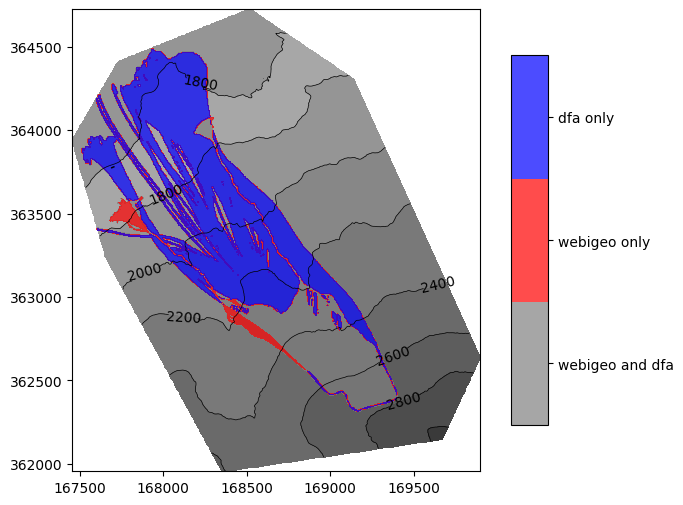

In [591]:

comparison = np.zeros_like(velocity, dtype=int)
only_dfa = ~(velocity > 0) & (dfa_flow_velocity > 0)
only_webigeo = (velocity > 0) & ~(dfa_flow_velocity > 0)
both = (velocity > 0) & (dfa_flow_velocity > 0)
array = np.zeros(x.shape, dtype=int)
comparison[both] = 1
comparison[only_webigeo] = 2
comparison[only_dfa] = 3
cmap = ListedColormap(['gray', 'red', 'blue'])  # White for False, Red for True

# Plot the boolean array as a contour plot
fig, ax = plt.subplots(figsize=(8, 6))

plot_dem(ax, corrected_dem, xx, yy)
cont = ax.contourf(xx, yy, comparison, cmap=cmap, levels=[0.5, 1.5, 2.5, 3.5], alpha=0.7)
cbar = fig.colorbar(cont, ax=ax, ticks=[0, 1, 2, 3], shrink=0.8, aspect=10)
cbar.ax.set_yticklabels(["No avalanche", "webigeo and dfa", "webigeo only", "dfa only"])
# cbar.set_label('Boolean Value')
ax.set_aspect('equal')
print

np.float64(-86.45870479324168)

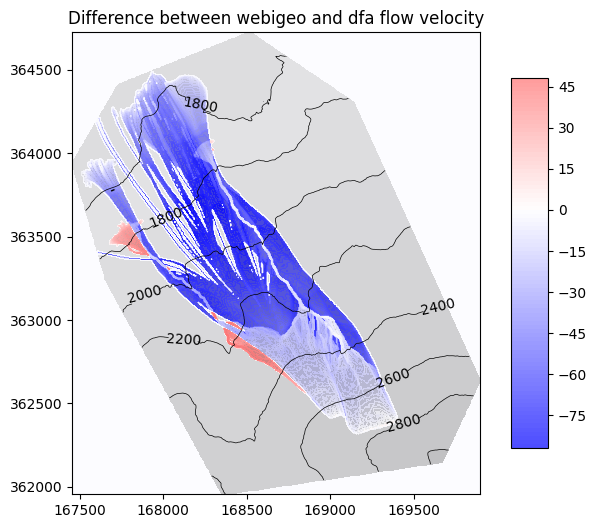

In [593]:

v_diff = velocity - dfa_flow_velocity
v_diff = v_diff[~np.isnan(v_diff)]
fig, ax = plt.subplots(figsize=(8, 6))
plot_dem(ax, corrected_dem, xx, yy)
cont = ax.contourf(x, y, velocity - dfa_flow_velocity, cmap="bwr", alpha=0.7, levels=100, norm=colors.CenteredNorm())
cbar = fig.colorbar(cont, ax=ax, shrink=0.8, aspect=10)
# cbar.set_label('Boolean Value')
ax.set_aspect('equal')
ax.set(title="Difference between webigeo and dfa flow velocity")
np.min((velocity - dfa_flow_velocity))

Unpickled Data:
dict_keys(['nPart', 'x', 'y', 'z', 'm', 'idFixed', 'totalEnthalpy', 'massPerPart', 'mTot', 'h', 'ux', 'uy', 'uz', 'uAcc', 'velocityMag', 'trajectoryLengthXY', 'trajectoryLengthXYCor', 'trajectoryLengthXYZ', 'trajectoryAngle', 'stoppCriteria', 'kineticEne', 'potentialEne', 'peakKinEne', 'peakForceSPH', 'forceSPHIni', 'peakMassFlowing', 'simName', 'xllcenter', 'yllcenter', 'nExitedParticles', 'dmDet', 'ID', 'nID', 'parentID', 't', 'nPPK', 'inCellDEM', 'indXDEM', 'indYDEM', 'indPartInCell', 'partInCell', 'secondaryReleaseInfo', 'iterate', 'dt', 'gEff', 'curvAcc', 'massEntrained', 'massDetrained'])
Number of particles: 26359


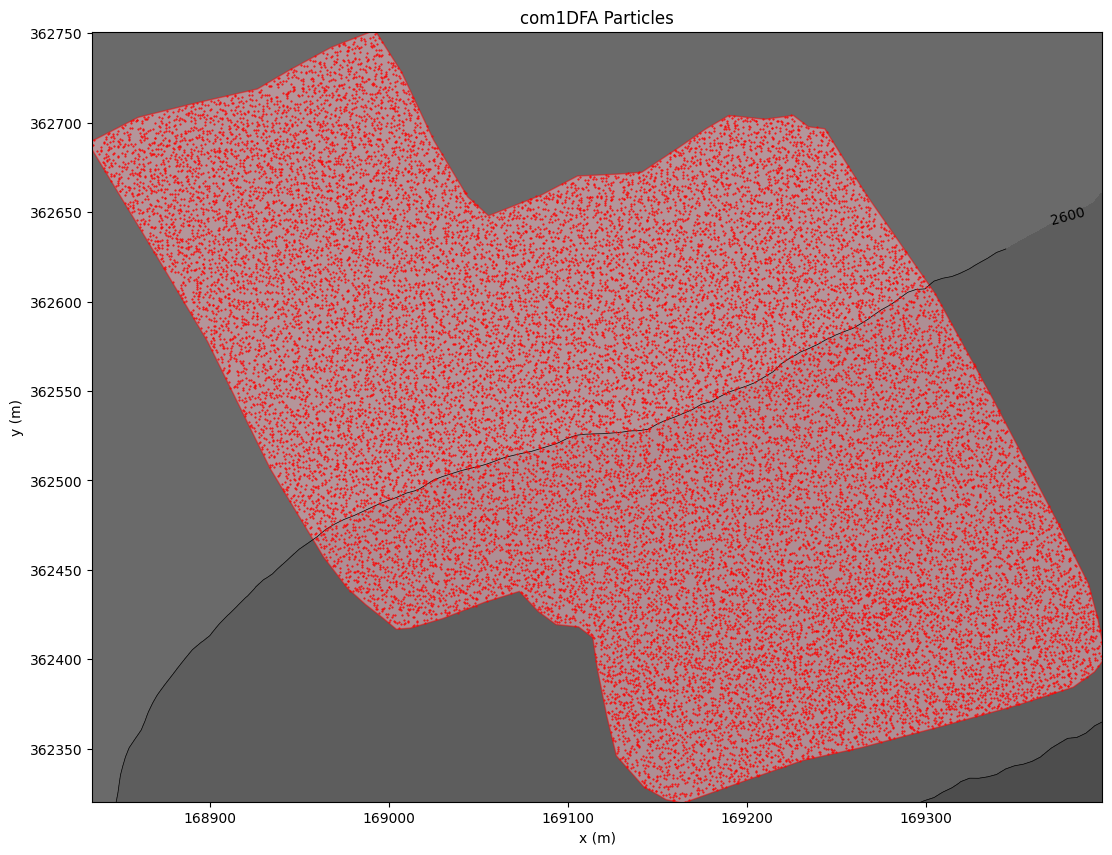

In [585]:
# plot com1DFA particles
import pickle

# Path to the pickle file
avaframe_output_dir
file_path = avaframe_output_dir / r"particles\particles_relWog_fcfa9c273d_C_L_null_dfa_0001.0000.pickle"

# Unpickle the file
with open(file_path, "rb") as file:  # Open the file in binary read mode
    data = pickle.load(file)  # Deserialize the file content

# Print the unpickled data
print("Unpickled Data:")
print(data.keys())
# plot_dem(ax, corrected_dem, xx, yy)
fig, ax = plot_inputs(xx, yy, corrected_dem, release_areas)
ax.plot(data["x"] + dem_header['xllcenter'], data["y"] + dem_header['yllcenter'], "r.", markersize=1)
ax.set(xlim=(data["x"].min() + dem_header['xllcenter'], data["x"].max() + dem_header['xllcenter']), ylim=(data["y"].min() + dem_header['yllcenter'], data["y"].max() + dem_header['yllcenter']))
ax.set(title="com1DFA Particles")
print(f"Number of particles: {len(data['x'])}")